## Saving a Classification Model

This is a minimal example showing how to train a fastai model on Kaggle, and save it to then be used in an app on huggingfaces.

In [2]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# Make sure we've got the latest version of fastai:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

In [6]:
# define our search utility function
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *
import time, json
from fastai.vision.all import *
from fastdownload import download_url

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

First we download and clean our data, which is going to be the classic question of 'hot dog or sandwich' (or burger).
For some reason, `resize_images` now fails with `KeyError: FITS` every time I try and run it, so it has been removed. All it will do is slow down our training (which still sucks, but doesn't totally block us from training).

In [60]:
%%time

categories = 'hot dog', 'sandwich', 'hamburger'
base_path = Path('food pics')

for c in categories:
    dest = (base_path/c)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{c} food'))
    time.sleep(5)
    print(f"Done downloading images for {c}")

failed = verify_images(get_image_files(base_path))
failed.map(Path.unlink)
print(f"{len(failed)} failed downloads")

for c in categories:
    dest = Path(base_path/c)
    images = get_image_files(dest)
    print(f"{len(images)} images for {c}")
    for i in images:
        try:
            resize_image(i, dest, src=dest, max_size=400)
        except KeyError as e:
            print(f"KeyError on file: {i}")
            continue

Done downloading images for hot dog
Done downloading images for sandwich
Done downloading images for hamburger
14 failed downloads
174 images for hot dog
194 images for sandwich
188 images for hamburger
CPU times: user 4.49 s, sys: 1.68 s, total: 6.17 s
Wall time: 59.8 s


Now we can create our `DataLoaders`:

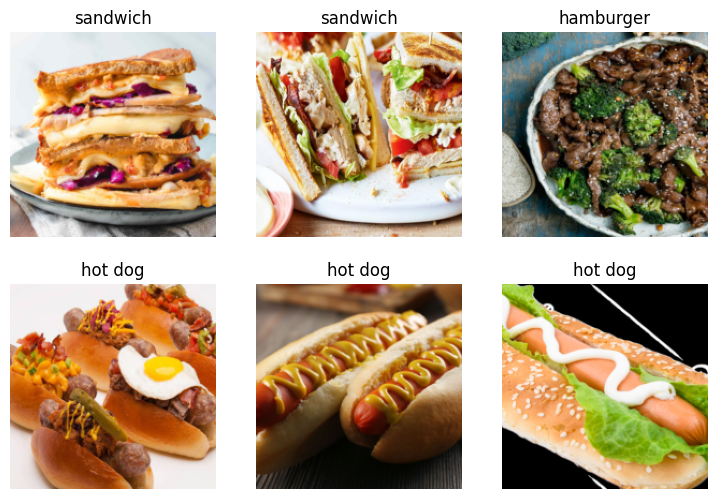

In [61]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(192, min_scale=0.3)],
).dataloaders(base_path, bs=32)

dls.show_batch(max_n=6)

... and train our model, a resnet18 (to keep it small and fast):

In [62]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.354908,0.591630,0.171171,00:16


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.665570,0.382637,0.135135,00:16
1,0.492490,0.297979,0.135135,00:16
2,0.390240,0.308404,0.108108,00:15
3,0.339008,0.281753,0.081081,00:16
4,0.290065,0.352396,0.117117,00:16
5,0.235279,0.326023,0.090090,00:17
6,0.210280,0.338358,0.099099,00:16
7,0.178205,0.314928,0.099099,00:16
8,0.151168,0.306224,0.090090,00:16
9,0.134942,0.300003,0.090090,00:16


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in by

Now we can export our trained `Learner`. This contains all the information needed to run the model:

In [63]:
learn.export('model.pkl')

Finally, open the Kaggle sidebar on the right if it's not already, and find the section marked "Output". Open the `/kaggle/working` folder, and you'll see `model.pkl`. Click on it, then click on the menu on the right that appears, and choose "Download". After a few seconds, your model will be downloaded to your computer, where you can then create your app that uses the model.